# Import necessary libraries

In [52]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets

In [53]:
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

### Convert date columns to datetime format

In [54]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Feature Engineering

### Aggregating transaction data for customer profiles

In [55]:
customer_transactions = transactions.groupby('CustomerID').agg({
    'TransactionID': 'count',  # Total transactions
    'TotalValue': ['sum', 'mean'],  # Total and average transaction value
    'TransactionDate': lambda x: (x.max() - x.min()).days / len(x)  # Transaction frequency
}).reset_index()

# Rename aggregated columns
customer_transactions.columns = ['CustomerID', 'TotalTransactions', 'TotalSpending', 'AvgTransactionValue', 'TransactionFrequency']

# Merge customer data with transaction features
customer_data = pd.merge(customers, customer_transactions, on='CustomerID', how='inner')

### Encoding categorical variable

In [56]:
le = LabelEncoder()
customer_data['RegionEncoded'] = le.fit_transform(customer_data['Region'])

### Extract SignupYear for clustering

In [57]:
customer_data['SignupYear'] = customer_data['SignupDate'].dt.year

### Drop unnecessary columns

In [58]:
customer_data_cleaned = customer_data[['TotalTransactions', 'TotalSpending', 'AvgTransactionValue', 
                                       'TransactionFrequency', 'RegionEncoded', 'SignupYear']]

# Scale the data

In [59]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data_cleaned)

# Clustering using K-Means

In [64]:
# Clustering using K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)
customer_data['Cluster'] = cluster_labels

# Evaluation metrics

In [66]:
db_index = davies_bouldin_score(scaled_data, cluster_labels)
print(f"Davies-Bouldin Index: {db_index}")
sil_score = silhouette_score(scaled_data, cluster_labels)
print(f"Silhouette Score: {sil_score}")

Davies-Bouldin Index: 1.5540894554736873
Silhouette Score: 0.1691973996721629


# Visualization

### PCA for 2D scatter plot

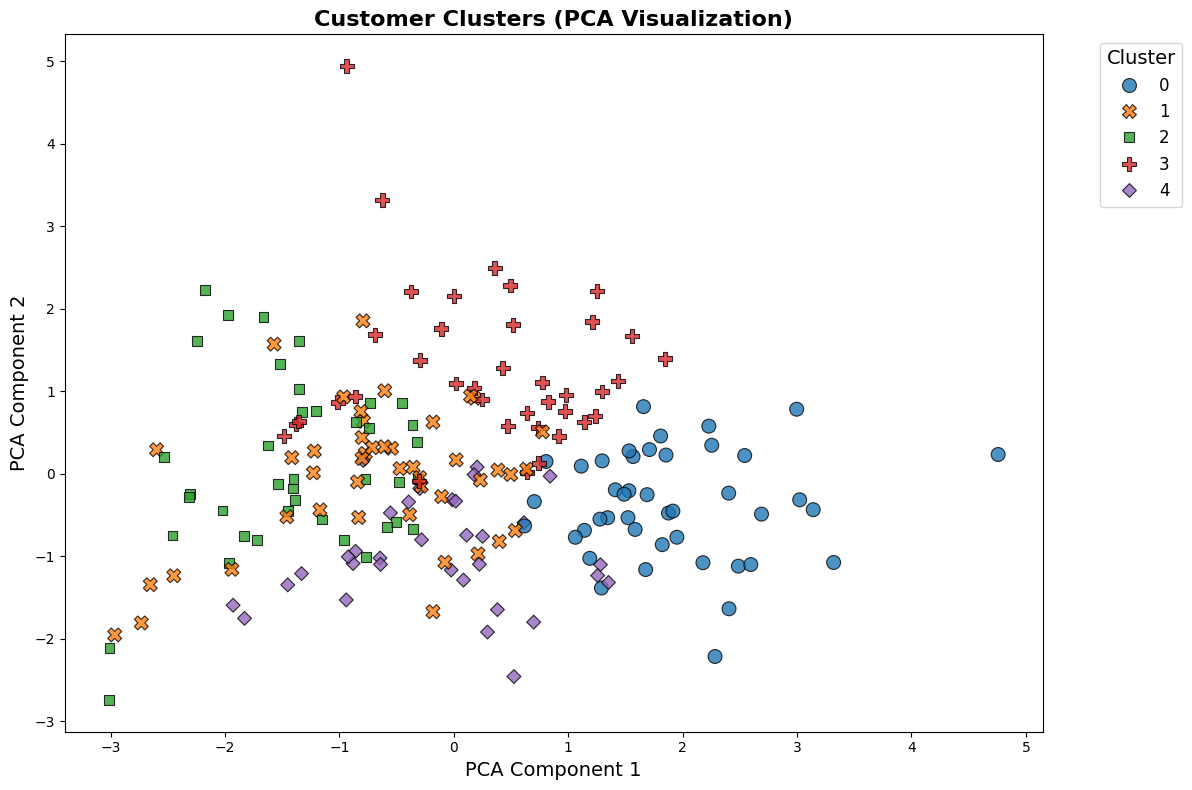

In [70]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=pca_data[:, 0],
    y=pca_data[:, 1],
    hue=customer_data['Cluster'],
    palette='tab10',
    style=customer_data['Cluster'],
    s=100,
    alpha=0.8,
    edgecolor='black'
)
plt.title('Customer Clusters (PCA Visualization)', fontsize=16, fontweight='bold')
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('PCA Component 2', fontsize=14)
plt.legend(title='Cluster', fontsize=12, title_fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Bar plot of spending by cluster

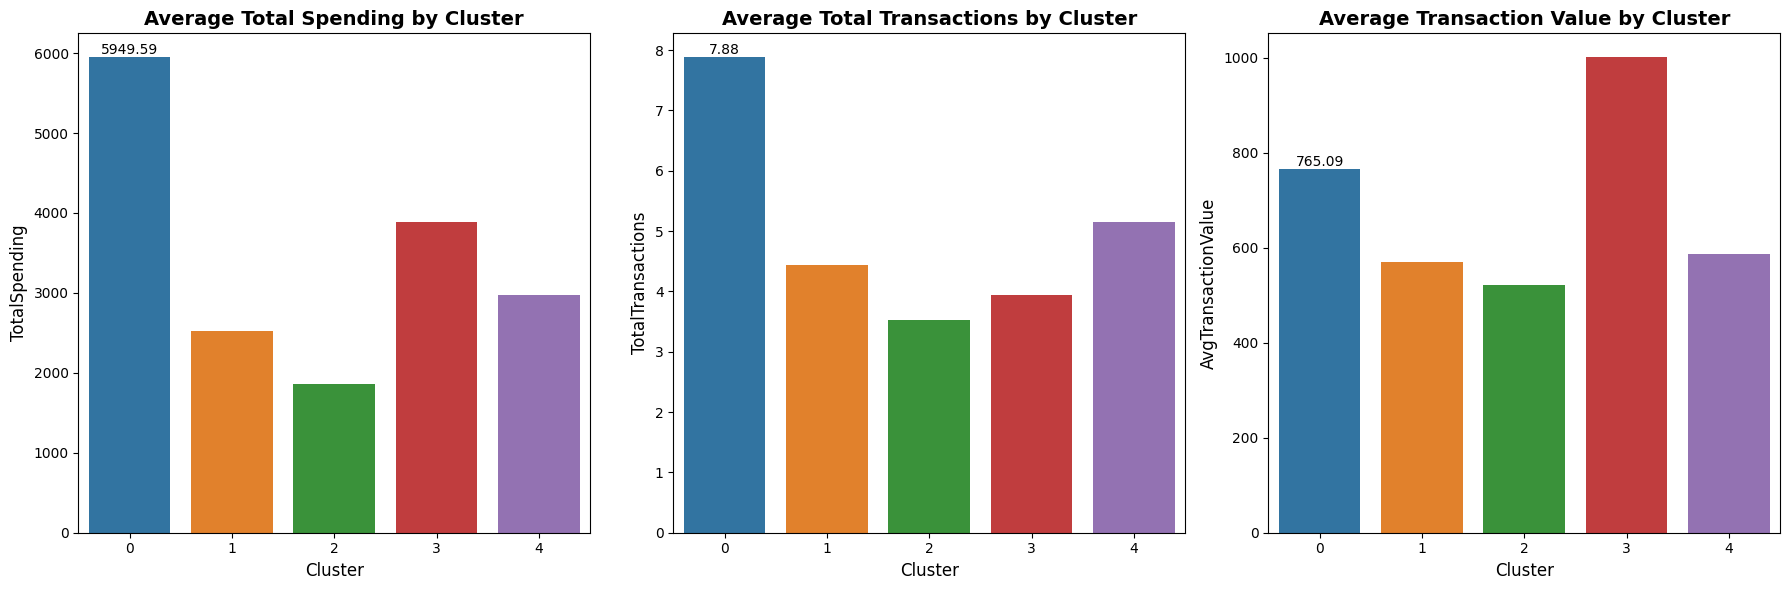

In [71]:
cluster_summary = customer_data.groupby('Cluster').agg({
    'TotalSpending': 'mean',
    'TotalTransactions': 'mean',
    'AvgTransactionValue': 'mean'
}).reset_index()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
metrics = ['TotalSpending', 'TotalTransactions', 'AvgTransactionValue']
titles = ['Average Total Spending by Cluster', 'Average Total Transactions by Cluster', 'Average Transaction Value by Cluster']

for i, metric in enumerate(metrics):
    sns.barplot(data=cluster_summary, x='Cluster', y=metric, palette='tab10', ax=axes[i])
    axes[i].set_title(titles[i], fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Cluster', fontsize=12)
    axes[i].set_ylabel(metric, fontsize=12)
    axes[i].bar_label(axes[i].containers[0], fmt='%.2f')

plt.tight_layout()
plt.show()